In [18]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2022-03-08 15:25:17 +01:00)


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
time: 2.17 s (started: 2022-02-23 22:32:45 +01:00)


In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [143]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Activation,Input,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

from lime import lime_image
import time

time: 0 ns (started: 2022-03-08 16:40:10 +01:00)


In [3]:
#define directory path => adapted to my laptop
root_dir ='C:/Users/ANTOINE/Project_Mushroom/' 
raw_data_dir = root_dir + 'raw_data/' #raw images folder
DL_dir = root_dir + 'deep_learning/' #Deep Learning folder

csv_file_paths = 'image_and_json_data.csv'



In [4]:
csv_file_paths = 'image_and_json_data.csv'
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

208774 rows in the file


file_name                                          file_path  resolution  \
0  1208.jpg  C:/Users/ANTOINE/Project_Mushroom/row_data\ima...  (243, 320)   
1  1604.jpg  C:/Users/ANTOINE/Project_Mushroom/row_data\ima...  (320, 164)   
2  1608.jpg  C:/Users/ANTOINE/Project_Mushroom/row_data\ima...  (320, 286)   
3    29.jpg  C:/Users/ANTOINE/Project_Mushroom/row_data\ima...  (240, 320)   
4   680.jpg  C:/Users/ANTOINE/Project_Mushroom/row_data\ima...  (240, 320)   

  file_year  image_id format  observation       label  \
0      ages      1208    jpg         1007  Agaricales   
1      ages      1604    jpg         1535  Agaricales   
2      ages      1608    jpg         1537  Agaricales   
3      ages        29    jpg           23  Agaricales   
4      ages       680    jpg          536    Agaricus   

                                     image_url  user  ...  \
0  http://mushroomobserver.org/images/320/1208    25  ...   
1  http://mushroomobserver.org/images/320/1604    43  ...   
2  http://mushroomobserver.org/images/320/1608    43  ...   
3    http://mushroomobserver.org/images/320/29     1  ...   
4   http://mushroomobserver.org/images/320/680     1  ...   

  gbif_info.canonicalName  gbif_info.phylumKey  gbif_info.class  \
0              Agaricales                 34.0   Agaricomycetes   
1              Agaricales                 34.0   Agaricomycetes   
2              Agaricales                 34.0   Agaricomycetes   
3              Agaricales                 34.0   Agaricomycetes   
4                Agaricus                 34.0   Agaricomycetes   

  gbif_info.synonym gbif_info.scientificName  gbif_info.genus gbif_info.order  \
0             False               Agaricales              NaN      Agaricales   
1             False               Agaricales              NaN      Agaricales   
2             False               Agaricales              NaN      Agaricales   
3             False               Agaricales              NaN      Agaricales   
4             False                 Agaricus         Agaricus      Agaricales   

  gbif_info.note  gbif_info                          json_file  
0            NaN        NaN  row_data\json\observations_0.json  
1            NaN        NaN  row_data\json\observations_0.json  
2            NaN        NaN  row_data\json\observations_0.json  
3            NaN        NaN  row_data\json\observations_0.json  
4            NaN        NaN  row_data\json\observations_0.json  

[5 rows x 38 columns]

In [5]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)']

# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
print(df_paths['gbif_info.class'].value_counts())

# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

Agaricomycetes    72246
Name: gbif_info.class, dtype: int64


gbif_info.family  size
0          Agaricaceae  5090
1       Albatrellaceae   200
2          Amanitaceae  4679
3    Amylocorticiaceae    16
4      Amylostereaceae     6
..                 ...   ...
99         Tubariaceae   212
100     Tulasnellaceae    37
101    Tulostomataceae     2
102        Typhulaceae    39
103      Xenasmataceae    30

[104 rows x 2 columns]

In [6]:
# keep only top 7 families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:7].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

gbif_info.family  size
0       Agaricaceae  5090
1       Amanitaceae  4679
2        Boletaceae  5977
3    Cortinariaceae  3931
4       Russulaceae  5911
5    Strophariaceae  4369
6  Tricholomataceae  4601

In [7]:
# subset col of interest + label encoding
df = df_paths[['file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

file_path gbif_info.family label
5  C:/Users/ANTOINE/Project_Mushroom/row_data\ima...      Agaricaceae     0
6  C:/Users/ANTOINE/Project_Mushroom/row_data\ima...      Agaricaceae     0
7  C:/Users/ANTOINE/Project_Mushroom/row_data\ima...      Agaricaceae     0
8  C:/Users/ANTOINE/Project_Mushroom/row_data\ima...      Agaricaceae     0
9  C:/Users/ANTOINE/Project_Mushroom/row_data\ima...      Agaricaceae     0

In [8]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 34558


label  gbif_info.family  size
0     0       Agaricaceae  5090
1     1    Strophariaceae  4369
2     2       Amanitaceae  4679
3     3        Boletaceae  5977
4     4  Tricholomataceae  4601
5     5    Cortinariaceae  3931
6     6       Russulaceae  5911

In [9]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Agaricaceae',
 '1': 'Strophariaceae',
 '2': 'Amanitaceae',
 '3': 'Boletaceae',
 '4': 'Tricholomataceae',
 '5': 'Cortinariaceae',
 '6': 'Russulaceae'}

In [10]:
# Train/test
df_train,df_test=train_test_split(df, train_size=0.8, stratify =df['label'], random_state=42)
# train / val 
df_train_,df_val_=train_test_split(df_train, train_size=0.8,stratify =df_train['label'],random_state=42)
print(df_train_.shape,df_val_.shape,df_test.shape)

(22116, 3) (5530, 3) (6912, 3)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_data = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                     x_col = "file_path",y_col="label", 
                                                     shuffle = False, # to match df_test order 
                                                     target_size=(240,320),
                                                     batch_size=16,
                                                     class_mode='sparse')

Found 6912 validated image filenames belonging to 7 classes.


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [13]:
efficientnet = tf.keras.models.load_model(root_dir + 'EFB1_final_model')

In [15]:
#assess performances 
start=time.time()
test_pred_class=[]
for i in range(432):
    test_pred_class_temp = efficientnet.predict(test_data[i][0]).argmax(axis = 1) # predictions test
    test_pred_class=np.concatenate([test_pred_class,test_pred_class_temp])
total_time=time.time()
print('durée totale calcul :',total_time)

durée totale calcul : 1646749484.0962949


In [27]:
#confusion matrix
y_test_class=[]
for i in range(432):
    y_test_class=np.concatenate([y_test_class,test_data[i][1]])
print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

         0.0       0.86      0.77      0.82      1018
         1.0       0.83      0.82      0.82       874
         2.0       0.91      0.89      0.90       936
         3.0       0.91      0.92      0.91      1196
         4.0       0.82      0.80      0.81       920
         5.0       0.78      0.90      0.84       786
         6.0       0.90      0.92      0.91      1182

    accuracy                           0.86      6912
   macro avg       0.86      0.86      0.86      6912
weighted avg       0.86      0.86      0.86      6912

time: 9.56 s (started: 2022-03-08 15:27:33 +01:00)


# post pred

In [28]:
y_test_class_df=pd.DataFrame(y_test_class)
y_test_count=pd.DataFrame(y_test_class_df.value_counts(),columns=['y_test_count'])
y_test_count=y_test_count.sort_index()
test_dict_label=pd.DataFrame(dict_label,index=['family']).transpose()
test_dict_label['y_test_count']=y_test_count['y_test_count'].values
test_dict_label=test_dict_label.reset_index()
test_dict_label=test_dict_label.rename({'index':'label'},axis=1)
test_dict_label

label            family  y_test_count
0     0       Agaricaceae          1018
1     1    Strophariaceae           874
2     2       Amanitaceae           936
3     3        Boletaceae          1196
4     4  Tricholomataceae           920
5     5    Cortinariaceae           786
6     6       Russulaceae          1182

time: 31 ms (started: 2022-03-08 15:27:43 +01:00)


In [29]:
test_pred_class=pd.DataFrame(test_pred_class)
test_pred_class=test_pred_class.rename({0:'pred_class'},axis=1)
test_pred_class

pred_class
0            5.0
1            3.0
2            6.0
3            5.0
4            6.0
...          ...
6907         3.0
6908         2.0
6909         4.0
6910         2.0
6911         1.0

[6912 rows x 1 columns]

time: 15 ms (started: 2022-03-08 15:27:45 +01:00)


In [30]:
y_test_class_df=y_test_class_df.rename({0:'real_class'},axis=1)
y_test_class_df

real_class
0            5.0
1            3.0
2            6.0
3            5.0
4            6.0
...          ...
6907         3.0
6908         2.0
6909         4.0
6910         2.0
6911         1.0

[6912 rows x 1 columns]

time: 0 ns (started: 2022-03-08 15:27:47 +01:00)


In [31]:
#sélection des indices par class parmi les 7158 images de Test
good_pred_indexes=[]
good_pred_indexes_class0=[]
good_pred_indexes_class1=[]
good_pred_indexes_class2=[]
good_pred_indexes_class3=[]
good_pred_indexes_class4=[]
good_pred_indexes_class5=[]
good_pred_indexes_class6=[]
for i in range(len(test_pred_class['pred_class'])):
    if (test_pred_class['pred_class'].iloc[i]==y_test_class_df['real_class'].iloc[i]):
        good_pred_indexes+=[i]
        if y_test_class_df['real_class'].iloc[i]==0:
            good_pred_indexes_class0+=[i]
        elif y_test_class_df['real_class'].iloc[i]==1:
            good_pred_indexes_class1+=[i]
        elif y_test_class_df['real_class'].iloc[i]==2:
            good_pred_indexes_class2+=[i]
        elif y_test_class_df['real_class'].iloc[i]==3:
            good_pred_indexes_class3+=[i]
        elif y_test_class_df['real_class'].iloc[i]==4:
            good_pred_indexes_class4+=[i]
        elif y_test_class_df['real_class'].iloc[i]==5:
            good_pred_indexes_class5+=[i]
        elif y_test_class_df['real_class'].iloc[i]==6:
            good_pred_indexes_class6+=[i]
            
good_pred_indexes_list=[good_pred_indexes_class0,
                       good_pred_indexes_class1,
                       good_pred_indexes_class2,
                       good_pred_indexes_class3,
                       good_pred_indexes_class4,
                       good_pred_indexes_class5,
                       good_pred_indexes_class6,]

time: 234 ms (started: 2022-03-08 15:27:50 +01:00)


In [32]:
print(np.array(good_pred_indexes_list[0]).size)
print(np.array(good_pred_indexes_list[1]).size)
print(np.array(good_pred_indexes_list[2]).size)
print(np.array(good_pred_indexes_list[3]).size)
print(np.array(good_pred_indexes_list[4]).size)
print(np.array(good_pred_indexes_list[5]).size)

print(np.array(good_pred_indexes).size)

788
715
834
1103
738
706
5967
time: 0 ns (started: 2022-03-08 15:27:52 +01:00)


In [33]:
#sélection des indices par class parmi les 7158 images de Test
bad_pred_indexes=[]
bad_pred_indexes_class0=[]
bad_pred_indexes_class1=[]
bad_pred_indexes_class2=[]
bad_pred_indexes_class3=[]
bad_pred_indexes_class4=[]
bad_pred_indexes_class5=[]
bad_pred_indexes_class6=[]
for i in range(len(test_pred_class['pred_class'])):
    if (test_pred_class['pred_class'].iloc[i]!=y_test_class_df['real_class'].iloc[i]):
        bad_pred_indexes+=[i]
        if y_test_class_df['real_class'].iloc[i]==0:
            bad_pred_indexes_class0+=[i]
        elif y_test_class_df['real_class'].iloc[i]==1:
            bad_pred_indexes_class1+=[i]
        elif y_test_class_df['real_class'].iloc[i]==2:
            bad_pred_indexes_class2+=[i]
        elif y_test_class_df['real_class'].iloc[i]==3:
            bad_pred_indexes_class3+=[i]
        elif y_test_class_df['real_class'].iloc[i]==4:
            bad_pred_indexes_class4+=[i]
        elif y_test_class_df['real_class'].iloc[i]==5:
            bad_pred_indexes_class5+=[i]
        elif y_test_class_df['real_class'].iloc[i]==6:
            bad_pred_indexes_class6+=[i]
            
bad_pred_indexes_list=[bad_pred_indexes_class0,
                       bad_pred_indexes_class1,
                       bad_pred_indexes_class2,
                       bad_pred_indexes_class3,
                       bad_pred_indexes_class4,
                       bad_pred_indexes_class5,
                       bad_pred_indexes_class6,]

time: 109 ms (started: 2022-03-08 15:27:55 +01:00)


In [34]:
print(np.array(bad_pred_indexes_list[0]).size)
print(np.array(bad_pred_indexes_list[1]).size)
print(np.array(bad_pred_indexes_list[2]).size)
print(np.array(bad_pred_indexes_list[3]).size)
print(np.array(bad_pred_indexes_list[4]).size)
print(np.array(bad_pred_indexes_list[5]).size)

print(np.array(good_pred_indexes).size)

230
159
102
93
182
80
5967
time: 0 ns (started: 2022-03-08 15:27:57 +01:00)


In [35]:
family_names=test_dict_label['family']
family_names

0         Agaricaceae
1      Strophariaceae
2         Amanitaceae
3          Boletaceae
4    Tricholomataceae
5      Cortinariaceae
6         Russulaceae
Name: family, dtype: object

time: 0 ns (started: 2022-03-08 15:27:59 +01:00)


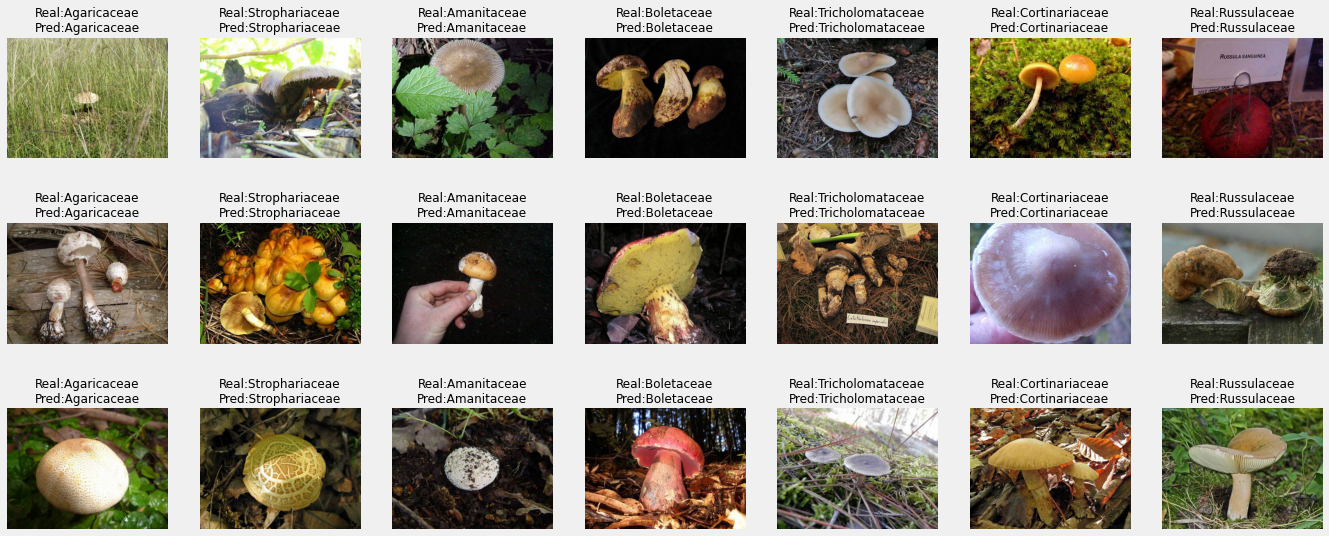

time: 1.2 s (started: 2022-03-08 15:28:01 +01:00)


In [36]:
fig,axs=plt.subplots(3,7,figsize=(21,9))
for col in range(7):
    if col==0:
        row=0
        for i in np.random.choice(good_pred_indexes_class0,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==1:
        row=0
        for i in np.random.choice(good_pred_indexes_class1,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==2:
        row=0
        for i in np.random.choice(good_pred_indexes_class2,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==3:
        row=0
        for i in np.random.choice(good_pred_indexes_class3,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==4:
        row=0
        for i in np.random.choice(good_pred_indexes_class4,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==5:
        row=0
        for i in np.random.choice(good_pred_indexes_class5,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==6:
        row=0
        for i in np.random.choice(good_pred_indexes_class6,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
#fig.savefig(root_dir +'Deep_learning/220215_02H39/EfficientNetB1_(240, 320)_7families_all_images_good_pred_examples.jpeg' );

# Heatmap

In [ ]:
index =  np.random.choice(good_pred_indexes_class3,size=1)

In [82]:
# choix 6 images parmi la class n, pour une bonne prédiction choisir success = True, sinon choisir success = False
def grad_image(n, success):

    if success ==True:
        indices_list = good_pred_indexes_list[n]
    else:
        indices_list = bad_pred_indexes_list[n]
        
    #choix de l'image
    list_indices_class1=[]    
    list_batch=[]
    list_batch_indice=[]

    indice=np.random.choice(indices_list,size=1)
    print(np.random.choice(indices_list,size=1))
    batch=indice//16
    list_batch.append(batch)
    j=indice%16
    list_batch_indice.append(j)
    test_data[batch].head()
    #print(np.array(test_data[batch][0][j],dtype=np.uint8))
    print(test_data[batch][0][j]) #[batch][0][indice]


    #explanation
    explanation = explainer.explain_instance(im, efficientnet.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask= explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    
    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]

    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    return

time: 0 ns (started: 2022-03-08 15:46:52 +01:00)


In [100]:
# choix 6 images parmi la class n, pour une bonne prédiction choisir success = True, sinon choisir success = False
def grad_image(n, success):
    fig=plt.figure(figsize=(21,8))
    k=1
    list_indices_class1=[]
    list_batch=[]
    list_batch_indice=[]
    if success ==True:
        indices_list = good_pred_indexes_list[n]
    else:
        indices_list = bad_pred_indexes_list[n]
        
    for i in np.random.choice(indices_list,size=1):
        #choix de l'image
        indice=i
        batch=indice//16
        list_batch.append(batch)
        j=indice%16
        list_batch_indice.append(j)
        im=np.array(test_data[batch][0][j],dtype=np.uint8) #[batch][0][indice]
        
        #explanation
        explanation = explainer.explain_instance(im, efficientnet.predict, top_labels=1, hide_color=0, num_samples=1000)
        temp, mask= explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

        #Select the same class explained on the figures above.
        ind =  explanation.top_labels[0]

        dict_heatmap = dict(explanation.local_exp[ind])
        heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

        #Plot. The visualization makes more sense if a symmetrical colorbar is used.
        fig=plt.figure(figsize=(21,4))
        ax = plt.subplot(1,3,1)
        label = 'image brute'
        plt.imshow(im)
        plt.axis('off')
        plt.title(label,size=12)
        
        ax = plt.subplot(1,3,2)
        plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
        label = 'gradient'
        plt.colorbar()
        plt.axis('off')
        plt.title(label,size=12)

        ax = plt.subplot(1,3,3)
        plt.imshow(mark_boundaries(temp, mask))
        label = 'image exliquée'
        plt.axis('off')
        plt.title(label,size=12)

        


time: 0 ns (started: 2022-03-08 16:09:50 +01:00)


  0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 1512x576 with 0 Axes>

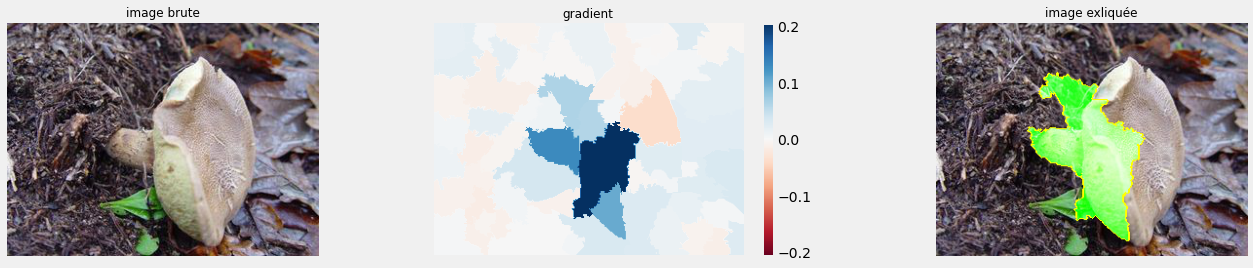

time: 1min 29s (started: 2022-03-08 16:09:53 +01:00)


In [101]:
grad_image(3,True)

# Analysis Function

In [ ]:
#On définie une première fonction qui permet d'avoir l'analyse de 6 bonnes ou mauvaises images d'une classe

In [144]:
# choix 6 images parmi la class n, pour une bonne prédiction choisir success = True, sinon choisir success = False
def plot_7_classes(n, success):
    fig=plt.figure(figsize=(21,8))
    k=1
    list_indices_class1=[]
    list_batch=[]
    list_batch_indice=[]
    if success ==True:
        indices_list = good_pred_indexes_list[n]
    else:
        indices_list = bad_pred_indexes_list[n]
    
    #choix image
    indice = np.random.choice(indices_list)
    batch=indice//16
    j=indice%16
    im=np.array(test_data[batch][0][j],dtype=np.uint8) #[batch][0][indice]
                
    print('Real class:', str(n) ,'\n'+'Pred class:',test_pred_class['pred_class'].iloc[indice])           
    #explanation
    explanation = explainer.explain_instance(im, efficientnet.predict, top_labels=7, hide_color=0, num_samples=1000)

    
        
    for i in range(7):
        
        #explanation
        temp, mask= explanation.get_image_and_mask(i, positive_only=False, num_features=5, hide_rest=False)

        #affichage de l'image choisie
        ax = plt.subplot(2,4,k)
        plt.imshow(mark_boundaries(temp, mask))
        label=str('Class :' + str(i) )
        plt.title(label,size=12)
        plt.axis('off')
        k+=1

time: 0 ns (started: 2022-03-08 16:41:48 +01:00)


In [148]:
# choix 6 images parmi la class n, pour une bonne prédiction choisir success = True, sinon choisir success = False
def plot_6_images(n, success):
    fig=plt.figure(figsize=(21,8))
    k=1
    list_indices_class1=[]
    list_batch=[]
    list_batch_indice=[]
    if success ==True:
        indices_list = good_pred_indexes_list[n]
    else:
        indices_list = bad_pred_indexes_list[n]
        
    for i in np.random.choice(good_pred_indexes_class6,size=6):
        #choix de l'image
        indice=i
        list_indices_class1.append(indice)#sauvegarde des indices pour le grad-cam
        batch=indice//16
        list_batch.append(batch)
        j=indice%16
        list_batch_indice.append(j)
        im=np.array(test_data[batch][0][j],dtype=np.uint8) #[batch][0][indice]

        #explanation
        explanation = explainer.explain_instance(im, efficientnet.predict, top_labels=1, hide_color=0, num_samples=1000)
        temp, mask= explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

        #affichage de l'image choisie
        ax = plt.subplot(2,3,k)
        plt.imshow(mark_boundaries(temp, mask))
        label=str('Real:'+family_names[3]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[indice]])
        plt.title(label,size=12)
        plt.axis('off')
        k+=1

time: 0 ns (started: 2022-03-08 16:53:25 +01:00)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

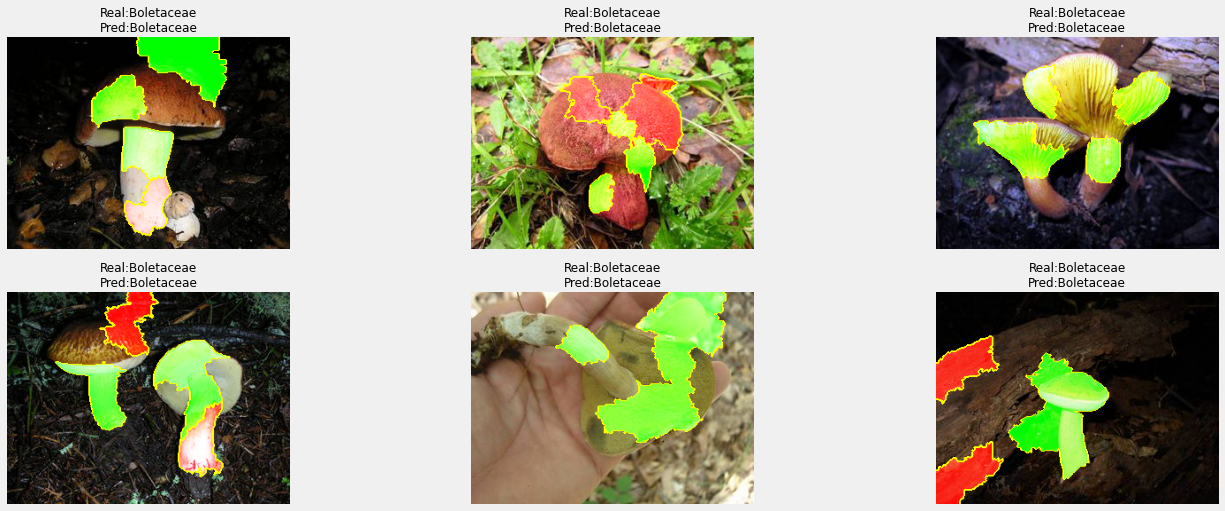

time: 9min 4s (started: 2022-03-03 08:10:17 +01:00)


In [128]:
plot_6_images(3,True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

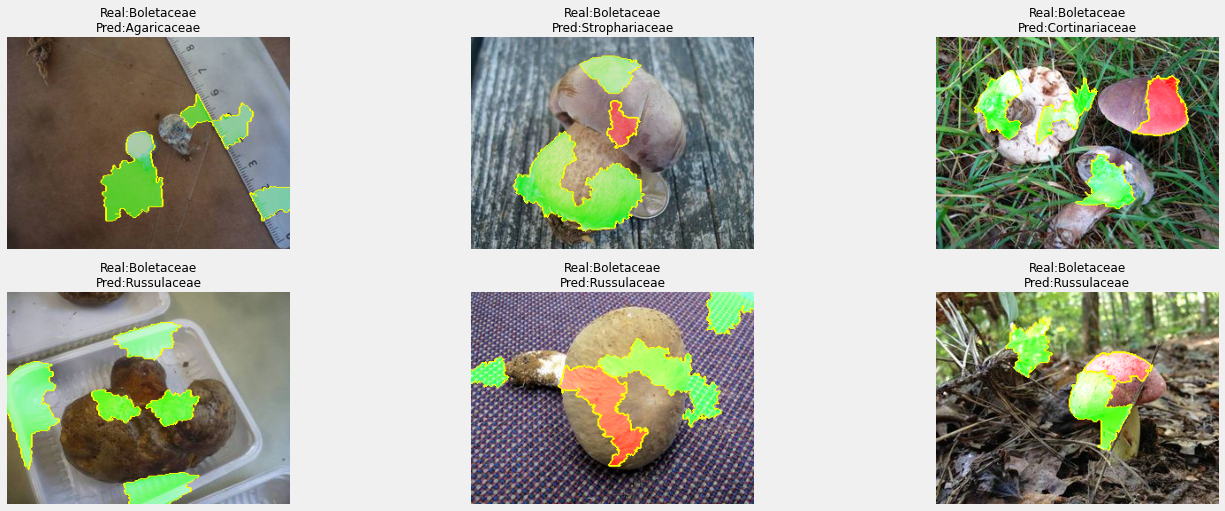

time: 9min 31s (started: 2022-03-03 07:18:19 +01:00)


In [89]:
plot_6_images(3,False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

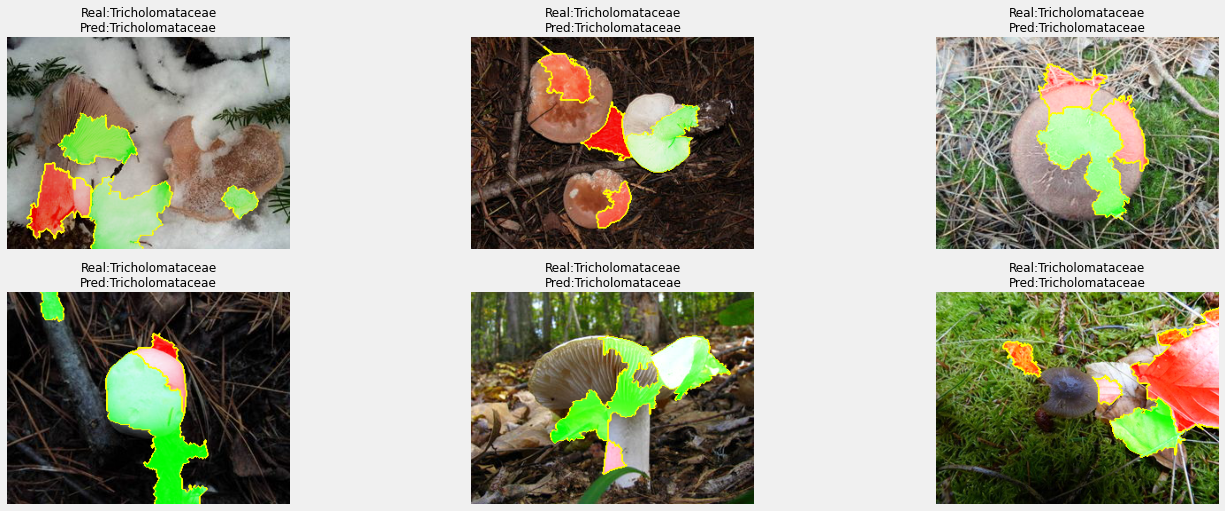

time: 9min (started: 2022-03-03 08:35:49 +01:00)


In [132]:
plot_6_images(4,True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

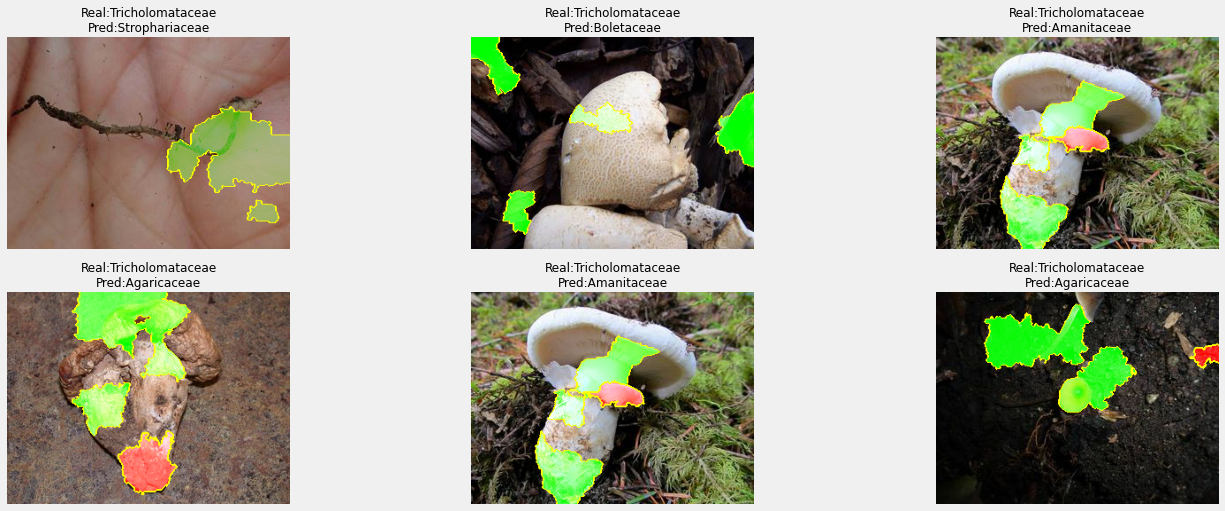

time: 8min 56s (started: 2022-03-03 08:44:50 +01:00)


In [133]:
plot_6_images(4,False)

In [ ]:
#On définie une fonction qui permet de montrer toutes les probabilités d'une classe pour une image 

Real class: 3 
Pred class: 0.0


  0%|          | 0/1000 [00:00<?, ?it/s]

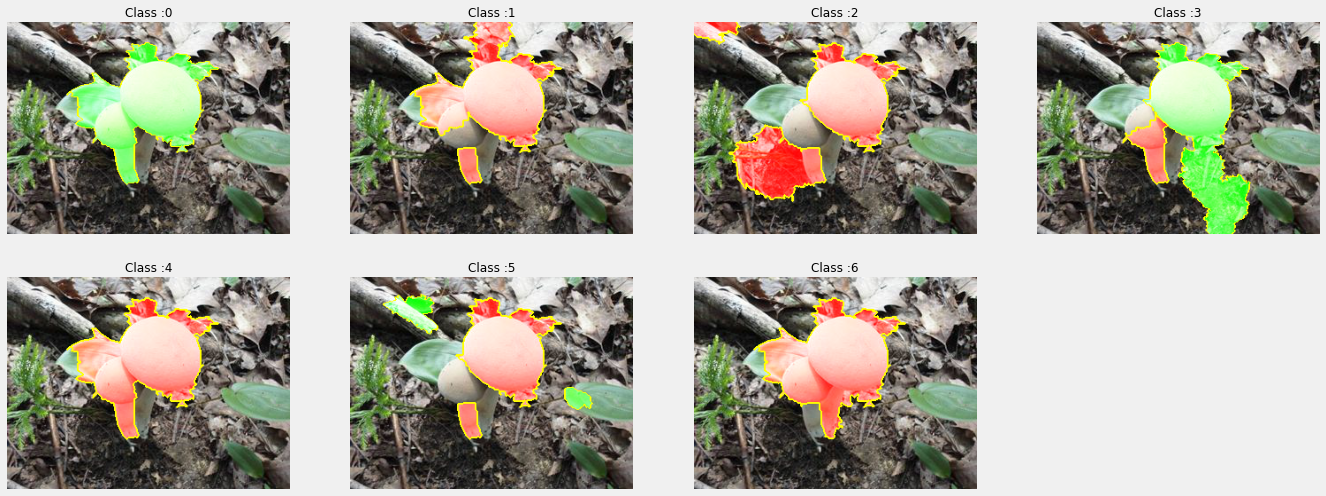

time: 1min 21s (started: 2022-03-08 16:35:50 +01:00)


In [142]:
plot_7_classes(3, False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

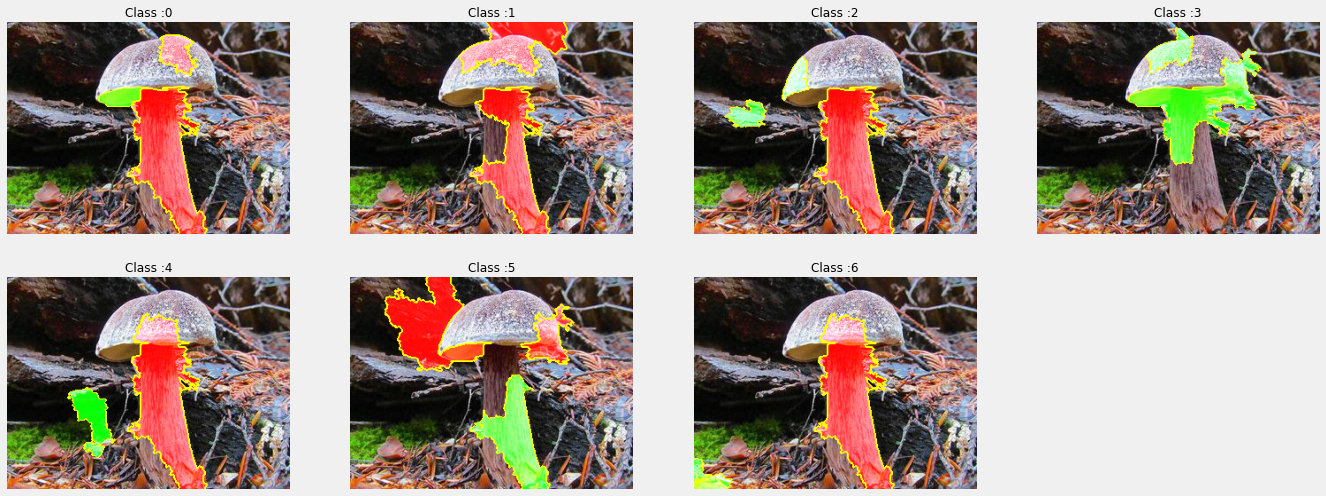

time: 11min 15s (started: 2022-03-03 07:36:55 +01:00)


In [96]:
plot_7_classes(3, True)